<img src="https://raw.githubusercontent.com/harmonize-tools/socio4health/main/docs/source/_static/Harmonize_LogoH.png" alt="image info" height="100" width="200"/> <img src="https://raw.githubusercontent.com/harmonize-tools/socio4health/main/docs/source/_static/image.png" alt="image info" height="100" width="100"/>

# Hands-on with socio4health: effects of hydrometeorologigcal hazards and urbanization on dengue risk in Brazil 



**Run the tutorial via free cloud platforms:** [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/harmonize-tools/socio4health/HEAD?urlpath=%2Fdoc%2Ftree%2Fdocs%2Fsource%2Fnotebooks%2Fexample_colombia.ipynb) <a target="_blank" href="https://colab.research.google.com/github/harmonize-tools/socio4health/blob/main/docs/source/notebooks/example_brazil.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

This notebook provides a real-world example of how to use **socio4health** to **retrieve**, **harmonize** and **analyze** **socioeconomic and demographic**  variables, such as the level of urbanization and access to water supply in Brazil, to recreate the dataset used in the publication *Combined effects of hydrometeorological hazards and urbanisation on dengue risk in Brazil: a spatiotemporal modelling study* by Lowe et al., published in *The Lancet Planetary Health* in 2021 ([DOI](https://doi.org/10.1016/S2542-5196(20)30292-8)). The study evaluated how the association between hydrometeorological events and **dengue** risk varies with these variables. This tutorial assumes an **intermediate** or **advanced** understanding of **Python** and data manipulation.

## Setting up the environment

To run this notebook, you need to have the following prerequisites:

- **Python 3.10+**

Additionally, you need to install the `socio4health` and `pandas` package, which can be done using ``pip``:



In [ ]:
!pip install socio4health pandas -q

In [ ]:
import sys

custom_path = "../../../src"
if custom_path not in sys.path:
    sys.path.insert(0, custom_path)

## Import Libraries

To perform the data extraction, the `socio4health` library provides the `Extractor` class for data extraction, and the `Harmonizer` class for data harmonization of the retrieved date. `pandas` will be used for data manipulation. Additionally, we will use some utility functions from the `socio4health.utils.harmonizer_utils` module to standardize and translate the dictionary.


In [ ]:
import re
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from socio4health import Extractor
from socio4health.harmonizer import Harmonizer
from socio4health.utils import harmonizer_utils, extractor_utils

# 1. Load and standardize the dictionary
To harmonize the data, provide a dictionary that describes the variables in the dataset. The study retrieved data from the 2010 census, from DATASUS


[here](https://microdatos.dane.gov.co/index.php/catalog/643/download/14045). Create a raw dictionary, which we will then standardize and translate to English. Follow the steps in the tutorial ["How to Create a Raw Dictionary for Data Harmonization"](https://harmonize-tools.github.io/socio4health/dictionary.html) to create a raw dictionary in Excel format.



In [3]:
raw_dic = pd.read_excel("../../../../Socio4HealthData/Dictionaries/Brazil/Diccionario Crudo Censo2.xlsx")
dic=harmonizer_utils.standardize_dict(raw_dic)
colnames, colspecs =extractor_utils.parse_fwf_dict(dic)
dic

c:\Users\Juan\OneDrive - Universidad de los andes\Uniandes\2025\Harmonize\socio4health\docs\source\notebooks\../../../src\socio4health\utils\harmonizer_utils.py:99: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_process_group, include_groups=True)\


,variable_name,question,description,value,initial_position,final_position,size,dec,type,possible_answers
0,V0402,a responsabilidade pelo domicílio é de:,NaN,1.0; 2.0; 9.0,107.0,107.0,1.0,NaN,C,apenas um morador; mais de um morador; ignorado
1,V0209,"abastecimento de água, canalização:",NaN,1.0; 2.0; 3.0,90.0,90.0,1.0,NaN,C,"sim, em pelo menos um cômodo; sim, só na propr..."
2,V0208,"abastecimento de água, forma:",NaN,1.0; 2.0; 3.0; 4.0; 5.0; 6.0; 7.0; 8.0; 9.0; 10.0,88.0,89.0,2.0,NaN,C,rede geral de distribuição; poço ou nascente n...
3,V6210,adequação da moradia,NaN,1.0; 2.0; 3.0,144.0,144.0,1.0,NaN,C,adequada; semi-adequada; inadequada
4,V0301,alguma pessoa que morava com você(s) estava mo...,NaN,1.0; 2.0,104.0,104.0,1.0,NaN,C,sim; não
...,...,...,...,...,...,...,...,...,...,...
71,V0214,"televisão, existência:",NaN,1.0; 2.0,95.0,95.0,1.0,NaN,C,sim; não
72,V4002,tipo de espécie:,NaN,11.0; 12.0; 13.0; 14.0; 15.0; 51.0; 52.0; 53.0...,56.0,57.0,2.0,NaN,C\n,casa; casa de vila ou em condomínio; apartamen...
73,V0001,unidade da federação:,NaN,11.0; 12.0; 13.0; 14.0; 15.0; 16.0; 17.0; 21.0...,1.0,2.0,2.0,NaN,A,rondônia; acre; amazonas; roraima; pará; amapá...
74,V2011,valor do aluguel (em reais),NaN,NaN,59.0,64.0,6.0,NaN,N,NaN


In [10]:
bra_online_extractor = Extractor(input_path="https://www.ibge.gov.br/estatisticas/sociais/saude/9662-censo-demografico-2010.html?=&t=microdados",
                                 down_ext=['.txt','.zip'],
                                 output_path="../../../../input/IBGE_2010",
                                 key_words=["^[A-Z]+\.zip$"],
                                 depth=0, is_fwf=True, colnames=colnames, colspecs=colspecs)
bra_Censo_2010 = bra_online_extractor.extract()

<>:4: SyntaxWarning: invalid escape sequence '\.'
<>:4: SyntaxWarning: invalid escape sequence '\.'
C:\Users\EQUIPO\AppData\Local\Temp\ipykernel_7704\3682625963.py:4: SyntaxWarning: invalid escape sequence '\.'
  key_words=["^[A-Z]+\.zip$"],
2025-09-01 11:09:03,919 - INFO - ----------------------
2025-09-01 11:09:03,919 - INFO - Starting data extraction...
2025-09-01 11:09:03,920 - INFO - Extracting data in online mode...
2025-09-01 11:09:03,920 - INFO - Scraping URL: https://www.ibge.gov.br/estatisticas/sociais/saude/9662-censo-demografico-2010.html?=&t=microdados with depth 0
2025-09-01 11:09:08,167 - INFO - Spider completed successfully for URL: https://www.ibge.gov.br/estatisticas/sociais/saude/9662-censo-demografico-2010.html?=&t=microdados
2025-09-01 11:09:08,169 - INFO - Downloading files to: ../../../../input/IBGE_2010
2025-09-01 11:26:03,197 - INFO - Processing (depth 0): RO.zip
2025-09-01 11:26:03,345 - INFO - Extracted: a53593a5_RO_Dom11.txt
2025-09-01 11:26:03,348 - INFO - 

In [4]:
bra_extractor = Extractor(input_path="../IBGE2010_",down_ext=['.txt'],is_fwf=True,output_path="../IBGE2010_", colnames=colnames, colspecs=colspecs)
bra_Censo_2010 = bra_extractor.extract()

2025-09-14 18:54:39,547 - INFO - ----------------------
2025-09-14 18:54:39,548 - INFO - Starting data extraction...
2025-09-14 18:54:39,549 - INFO - Extracting data in local mode...
Processing files: 100%|██████████| 86/86 [16:06<00:00, 11.24s/it]
2025-09-14 19:10:45,881 - INFO - Successfully processed 86/86 files
2025-09-14 19:10:45,881 - INFO - Extraction completed successfully.


In [5]:
har = Harmonizer()
har.similarity_threshold = 0.9
dfs = har.vertical_merge(bra_Censo_2010)

Merging groups: 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


In [6]:
dic = harmonizer_utils.translate_column(dic, "question", language="en")
dic = harmonizer_utils.translate_column(dic, "description", language="en")
dic = harmonizer_utils.translate_column(dic, "possible_answers", language="en")
dic = harmonizer_utils.classify_rows(dic, "question_en", "description_en", "possible_answers_en",
                                        new_column_name="category",
                                        MODEL_PATH="../../../../Socio4HealthData/input/bert_finetuned_classifier")
dic

question translated
description translated
possible_answers translated


Device set to use cpu


,variable_name,question,description,value,initial_position,final_position,size,dec,type,possible_answers,question_en,description_en,possible_answers_en,category
0,V0402,a responsabilidade pelo domicílio é de:,NaN,1.0; 2.0; 9.0,107.0,107.0,1.0,NaN,C,apenas um morador; mais de um morador; ignorado,The responsibility for the home is:,NaN,just a resident; more than one resident; ignored,Housing
1,V0209,"abastecimento de água, canalização:",NaN,1.0; 2.0; 3.0,90.0,90.0,1.0,NaN,C,"sim, em pelo menos um cômodo; sim, só na propr...","water supply, channeling:",NaN,"Yes, in at least one room; Yes, only on the pr...",Housing
2,V0208,"abastecimento de água, forma:",NaN,1.0; 2.0; 3.0; 4.0; 5.0; 6.0; 7.0; 8.0; 9.0; 10.0,88.0,89.0,2.0,NaN,C,rede geral de distribuição; poço ou nascente n...,"water supply, form:",NaN,General Distribution Network; well or source o...,Business
3,V6210,adequação da moradia,NaN,1.0; 2.0; 3.0,144.0,144.0,1.0,NaN,C,adequada; semi-adequada; inadequada,Housing Adequacy,NaN,adequate; semi-adherence; inadequate,Housing
4,V0301,alguma pessoa que morava com você(s) estava mo...,NaN,1.0; 2.0,104.0,104.0,1.0,NaN,C,sim; não,Someone who lived with you (s) was living in a...,NaN,Yes; no,Business
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,V0214,"televisão, existência:",NaN,1.0; 2.0,95.0,95.0,1.0,NaN,C,sim; não,"television, existence:",NaN,Yes; no,Identification
72,V4002,tipo de espécie:,NaN,11.0; 12.0; 13.0; 14.0; 15.0; 51.0; 52.0; 53.0...,56.0,57.0,2.0,NaN,C\n,casa; casa de vila ou em condomínio; apartamen...,Type of species:,NaN,home; village house or condominium; apartment;...,Housing
73,V0001,unidade da federação:,NaN,11.0; 12.0; 13.0; 14.0; 15.0; 16.0; 17.0; 21.0...,1.0,2.0,2.0,NaN,A,rondônia; acre; amazonas; roraima; pará; amapá...,Federation unit:,NaN,Rondônia; acre; Amazonas; Roraima; to; Amapá; ...,Business
74,V2011,valor do aluguel (em reais),NaN,NaN,59.0,64.0,6.0,NaN,N,NaN,Rental value (in reais),NaN,NaN,Business


In [7]:
har.dict_df = dic
har.categories = ["Housing"]
har.key_col = 'V0001'
filtered_ddfs = har.data_selector(dfs)

2025-09-14 19:11:30,280 - WARNING - key_col or key_val not defined, row-wise size will not be reduced


In [29]:
len(filtered_ddfs)

1

In [ ]:
filtered_ddfs[0].compute()

,V0001,V0402,V0209,V6210,V0205,V0204,V0203,V6204,V6203,V0207,V0401,V6531,V6529,V4002
0,51,2,0,<NA>,1,01,00,010,403,2,20,70503,2020100,10
1,51,2,0,<NA>,1,01,00,010,503,2,20,3080302,2020200,10
2,51,2,0,<NA>,1,01,00,010,701,1,20,001,2020000,10
3,51,2,0,<NA>,1,01,00,010,302,2,20,006,2020000,10
4,51,2,0,<NA>,1,01,00,010,702,1,20,004,2020100,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202874,22,0,1,0,0,43,10,000,100,4,<NA>,0 0,0 0 0,04
202875,22,0,1,0,0,40,20,000,100,1,<NA>,0 0,0 0 0,04
202876,22,0,1,9,0,17,30,000,100,4,<NA>,0 0,0 0 0,04
202877,22,0,1,0,0,15,30,000,100,4,<NA>,0 0,0 0 0,04


In [ ]:
ddf = filtered_ddfs[0][["V0001", "V0401"]]

ddf = ddf.assign(
    V0001 = ddf["V0001"].astype("category"),
    V0401 = dd.to_numeric(ddf["V0401"], errors="coerce").astype("float64").fillna(0.0)
).categorize(columns=["V0001"])

pop = ddf.groupby("V0001")["V0401"].sum(split_out=8).compute()

c:\Users\Juan\anaconda3\envs\social4health\Lib\site-packages\dask\dataframe\dask_expr\_groupby.py:1562: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  self._meta = self.obj._meta.groupby(


In [ ]:
row = dic.loc[dic["variable_name"]=="V0001", ["value","possible_answers"]].iloc[0]

vals = [s for s in re.split(r"\s*;\s*", str(row["value"]).strip(" ;")) if s]
labs = [s for s in re.split(r"\s*;\s*", str(row["possible_answers"]).strip(" ;")) if s]

idx = pop.index
if pd.api.types.is_integer_dtype(idx):
    keys = [int(float(v)) for v in vals]
elif pd.api.types.is_float_dtype(idx):
    keys = [float(v) for v in vals]
else:
    keys = [str(int(float(v))) for v in vals]

if len(keys) != len(labs):
    raise ValueError(f"Desalineación: {len(keys)} códigos vs {len(labs)} nombres")
code2name = dict(zip(keys, labs))

pop_named = pop.rename(index=code2name)


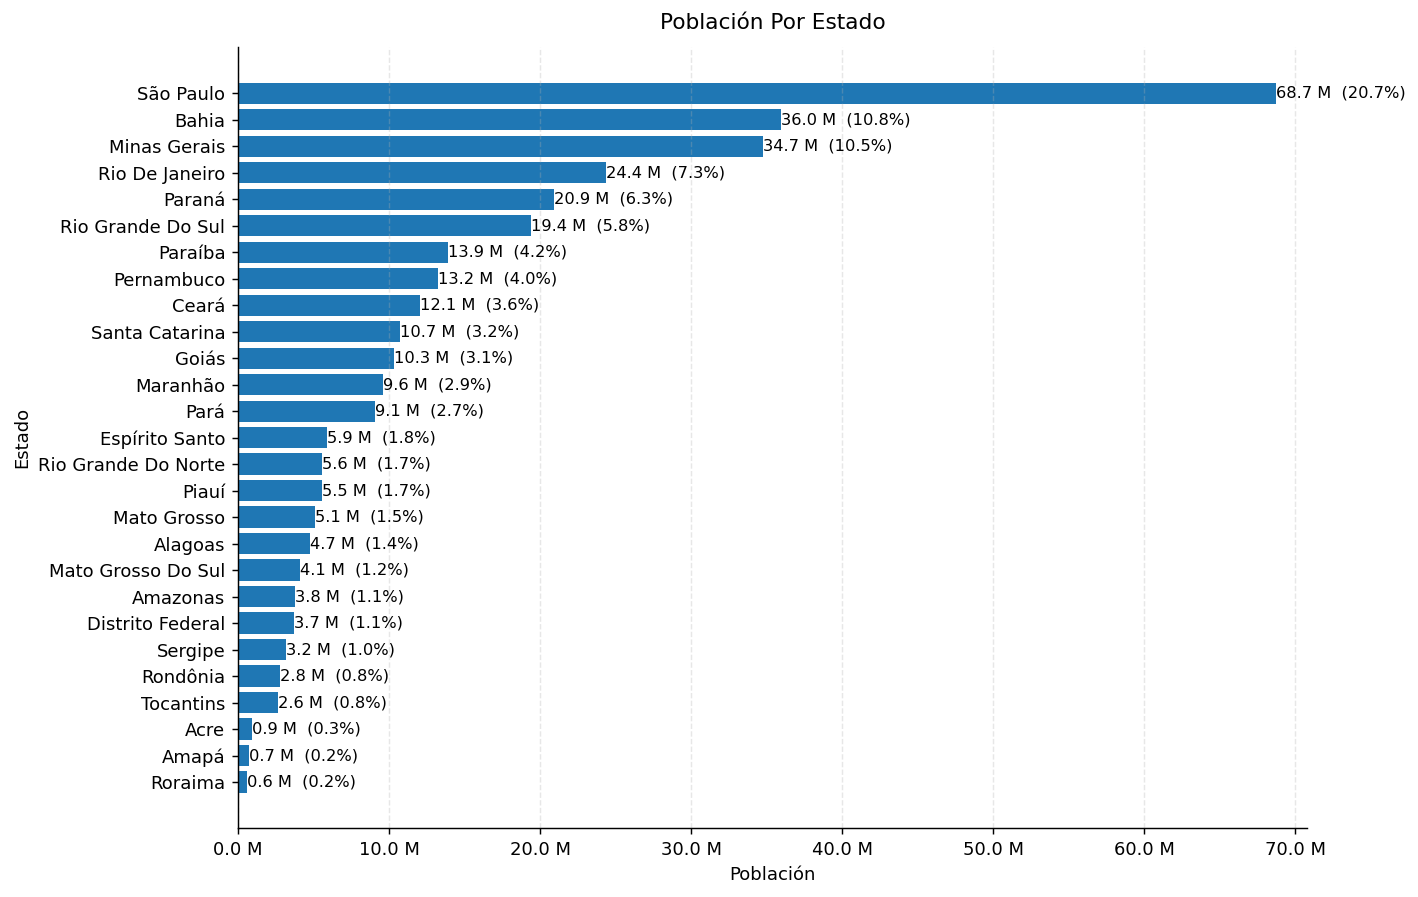

In [ ]:
top = pop_named.sort_values()
top_titled = top.copy()
top_titled.index = [str(s).title() for s in top.index]

fig, ax = plt.subplots(figsize=(11,7), dpi=130)
ax.barh(top_titled.index, top_titled.values)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_title(f"Población Por Estado", pad=10)
ax.set_xlabel("Población")
ax.set_ylabel("Estado")
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, p: f"{x/1e6:.1f} M"))

total = pop_named.sum()
for i, v in enumerate(top_titled.values):
    ax.text(v, i, f"{v/1e6:.1f} M  ({v/total:.1%})", va="center", ha="left", fontsize=9)

ax.grid(axis="x", linestyle="--", alpha=0.3)
plt.margins(x=0.03)
plt.tight_layout()
plt.show()